In [11]:
# # Forest Fire Data Exploration for Goa
# 
# This script explores the datasets used in the forest fire vulnerability and 
# prediction project for Goa, India. It is structured in sections that can be 
# easily converted to notebook cells later.

In [12]:
# CELL 1: Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import rasterio
from rasterio.plot import show

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

print("Libraries imported successfully!")

Libraries imported successfully!


In [17]:
# CELL 2: Data Inventory - List all files in the data directory

data_dir = '../data'
print(f"Checking contents of {data_dir} directory...")

if not os.path.exists(data_dir):
    print(f"Warning: {data_dir} directory not found!")
else:
    all_files = os.listdir(data_dir)
    
    # Group files by type
    shapefile_extensions = ['.shp', '.shx', '.dbf', '.prj', '.cpg']
    raster_extensions = ['.tif', '.tiff']
    
    # Organize files by category
    shapefiles = [f for f in all_files if any(f.endswith(ext) for ext in shapefile_extensions)]
    raster_files = [f for f in all_files if any(f.endswith(ext) for ext in raster_extensions)]
    other_files = [f for f in all_files if f not in shapefiles and f not in raster_files]
    
    # Extract unique shapefile base names (without extensions)
    shapefile_bases = set()
    for file in shapefiles:
        for ext in shapefile_extensions:
            if file.endswith(ext):
                shapefile_bases.add(file.replace(ext, ''))
    
    print("\nShapefiles (base names):")
    for base in shapefile_bases:
        print(f"- {base}")
    
    print("\nRaster files:")
    for file in raster_files:
        print(f"- {file}")
    
    print("\nOther files:")
    for file in other_files:
        print(f"- {file}")

Checking contents of data directory...

Shapefiles (base names):
- fire13_19
- pa_boundary
- fire20_23

Raster files:
- road.tif
- inputResampled.tif
- dem.tif

Other files:
- pa_boundary.qmd
- fire13_19.fix


Total fire events: 267
Fire events from 2013-2019: 197
Fire events from 2020-2023: 70

Columns in the fire dataset:
['bright_ti5', 'bright_ti4', 'acq_time', 'frp', 'Delta T', 'acq_date', 'confidence', 'scan', 'instrument', 'type', 'version', 'RiskNumeri', 'daynight', 'satellite', 'track', 'RiskCatego', 'geometry', 'latitude', 'longitude', 'system_ind']

Sample of fire data:
   bright_ti5  bright_ti4  acq_time    frp  Delta T    acq_date confidence  scan instrument type version  RiskNumeri daynight satellite  track RiskCatego                   geometry  latitude  longitude system_ind
0      297.82      334.69       726   4.47    36.87  26-04-2018          n  0.62      VIIRS    0       1         3.0        D         N   0.72  High Risk   POINT (74.19322 15.6126)       NaN        NaN        NaN
1      300.19      335.37       738   2.30    35.18  06-04-2013          n  0.38      VIIRS    0       1         3.0        D         N   0.59  High Risk  POINT (74.19879 15.30833)       NaN       

/var/folders/03/70byyv1n5g7d83j8pp_3_phc0000gn/T/ipykernel_70420/4137265159.py:30: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  fire_all['acq_date'] = pd.to_datetime(fire_all['acq_date'])


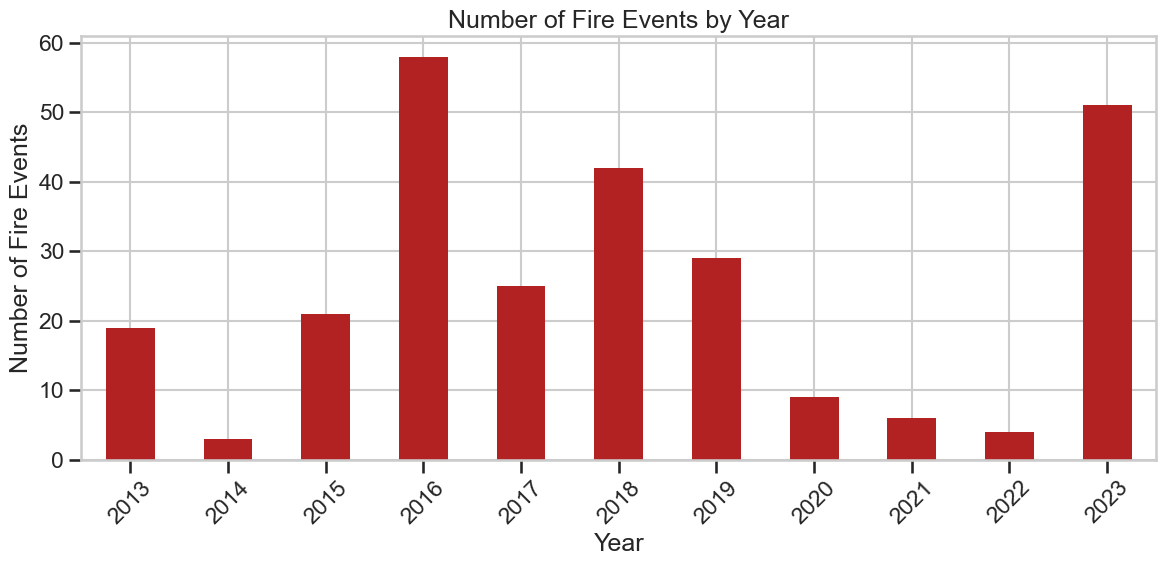

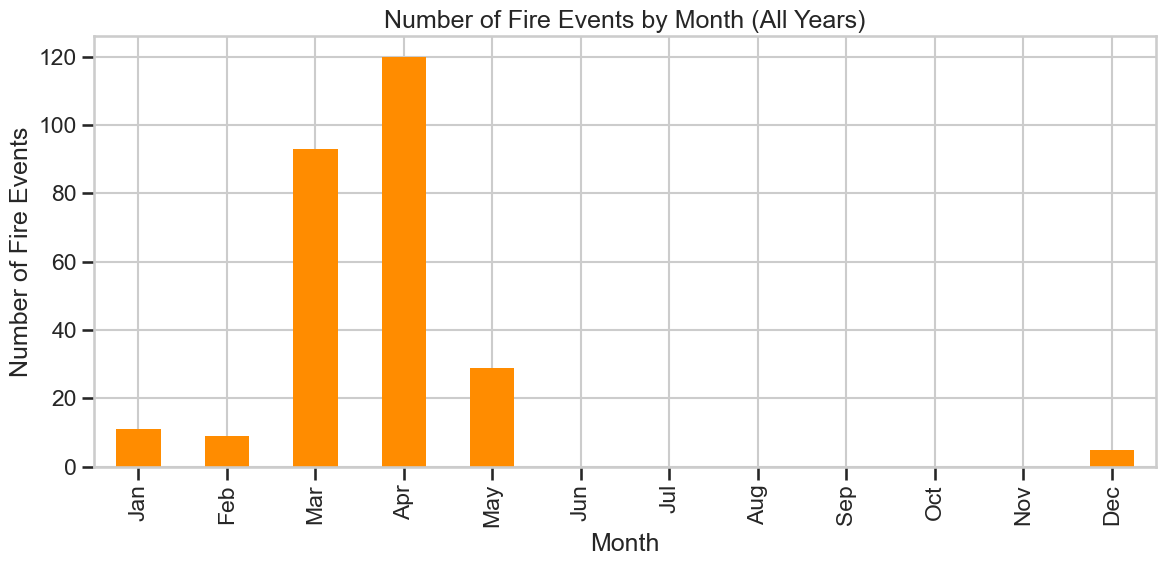

In [19]:
# CELL 3: Fire Events Data Analysis

try:
    # Load the fire events data
    fire13_19_path = os.path.join(data_dir, 'fire13_19.shp')
    fire20_23_path = os.path.join(data_dir, 'fire20_23.shp')
    
    if os.path.exists(fire13_19_path) and os.path.exists(fire20_23_path):
        fire13_19 = gpd.read_file(fire13_19_path)
        fire20_23 = gpd.read_file(fire20_23_path)
        
        # Combine datasets
        fire_all = pd.concat([fire13_19, fire20_23], ignore_index=True)
        
        print(f"Total fire events: {len(fire_all)}")
        print(f"Fire events from 2013-2019: {len(fire13_19)}")
        print(f"Fire events from 2020-2023: {len(fire20_23)}")
        
        # Preview the data
        print("\nColumns in the fire dataset:")
        print(fire_all.columns.tolist())
        
        print("\nSample of fire data:")
        print(fire_all.head().to_string())
        
        # Analyze temporal distribution if date field exists
        if 'acq_date' in fire_all.columns:
            # Convert to datetime if it's not already
            if not pd.api.types.is_datetime64_any_dtype(fire_all['acq_date']):
                fire_all['acq_date'] = pd.to_datetime(fire_all['acq_date'])
            
            # Extract year and month
            fire_all['year'] = fire_all['acq_date'].dt.year
            fire_all['month'] = fire_all['acq_date'].dt.month
            
            # Yearly distribution
            yearly_counts = fire_all.groupby('year').size()
            
            print("\nFire events by year:")
            for year, count in yearly_counts.items():
                print(f"  {year}: {count} events")
            
            # Monthly distribution
            monthly_counts = fire_all.groupby('month').size()
            month_names = {
                1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
            }
            
            print("\nFire events by month (all years combined):")
            for month, count in monthly_counts.items():
                print(f"  {month_names[month]}: {count} events")
            
            # Create and save yearly plot
            plt.figure(figsize=(12, 6))
            yearly_counts.plot(kind='bar', color='firebrick')
            plt.title('Number of Fire Events by Year')
            plt.xlabel('Year')
            plt.ylabel('Number of Fire Events')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('img/fire_events_by_year.png')
            print("Saved plot: fire_events_by_year.png")
            
            # Create and save monthly plot
            plt.figure(figsize=(12, 6))
            monthly_counts_labeled = pd.Series([monthly_counts.get(i, 0) for i in range(1, 13)], 
                                              index=[month_names[i] for i in range(1, 13)])
            monthly_counts_labeled.plot(kind='bar', color='darkorange')
            plt.title('Number of Fire Events by Month (All Years)')
            plt.xlabel('Month')
            plt.ylabel('Number of Fire Events')
            plt.tight_layout()
            plt.savefig('img/fire_events_by_month.png')
            print("Saved plot: fire_events_by_month.png")
            
    else:
        print("Fire event shapefiles not found.")
except Exception as e:
    print(f"Error analyzing fire data: {e}")

Study area boundary loaded successfully.
Boundary CRS: EPSG:4326
Boundary geometry type: Polygon
Study area size: 821.24 square kilometers
Saved plot: study_area_boundary.png
Saved plot: study_area_with_fires.png


/var/folders/03/70byyv1n5g7d83j8pp_3_phc0000gn/T/ipykernel_70420/77088353.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(years))


<Figure size 1000x1000 with 0 Axes>

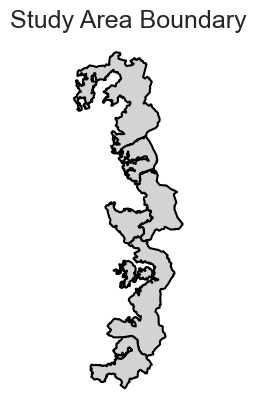

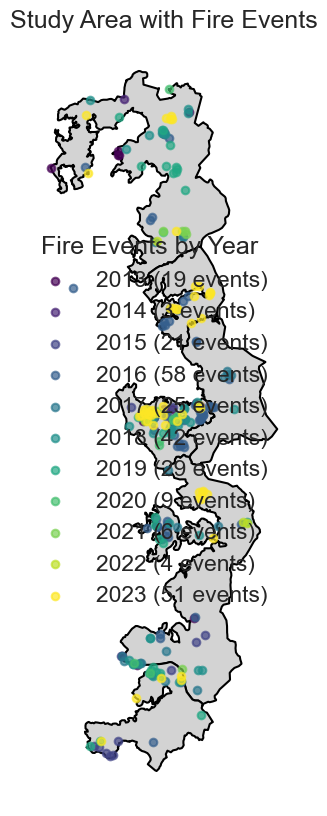

In [ ]:
# CELL 4: Study Area Boundary Analysis

try:
    # Load the boundary data
    boundary_path = os.path.join(data_dir, 'pa_boundary.shp')
    
    if os.path.exists(boundary_path):
        boundary = gpd.read_file(boundary_path)
        print(f"Study area boundary loaded successfully.")
        print(f"Boundary CRS: {boundary.crs}")
        print(f"Boundary geometry type: {boundary.geometry.geom_type.iloc[0]}")
        
        # Calculate area 
        if boundary.crs and boundary.crs.is_geographic:
            # If geographic coordinates (lat/lon), reproject to a projected CRS for area calculation
            boundary_projected = boundary.to_crs(epsg=3857)  # Web Mercator projection
            area_km2 = boundary_projected.area.sum() / 1e6  # Convert from square meters to square km
            print(f"Study area size: {area_km2:.2f} square kilometers")
        else:
            # If already in a projected CRS
            area_units = boundary.area.sum()
            print(f"Study area size: {area_units:.2f} square units (CRS units)")
        
        # Plot boundary
        plt.figure(figsize=(10, 10))
        boundary.plot(color='lightgray', edgecolor='black')
        plt.title('Study Area Boundary')
        plt.axis('off')
        plt.savefig('img/study_area_boundary.png')
        print("Saved plot: study_area_boundary.png")
        
        # Plot with fire points if available
        if 'fire_all' in locals():
            # Ensure same CRS
            if fire_all.crs != boundary.crs:
                fire_all = fire_all.to_crs(boundary.crs)
            
            plt.figure(figsize=(12, 10))
            boundary.plot(ax=plt.gca(), color='lightgray', edgecolor='black')
            
            # Plot fire events, colored by year if available
            if 'year' in fire_all.columns:
                years = sorted(fire_all['year'].unique())
                cmap = plt.cm.get_cmap('viridis', len(years))
                
                for i, year in enumerate(years):
                    year_data = fire_all[fire_all['year'] == year]
                    plt.scatter(
                        year_data.geometry.x,
                        year_data.geometry.y,
                        c=[cmap(i)],
                        label=f'{year} ({len(year_data)} events)',
                        alpha=0.7,
                        s=30
                    )
                plt.legend(title="Fire Events by Year")
            else:
                plt.scatter(
                    fire_all.geometry.x,
                    fire_all.geometry.y,
                    c='red',
                    label='Fire Events',
                    alpha=0.7,
                    s=30
                )
                plt.legend()
                
            plt.title('Study Area with Fire Events')
            plt.axis('off')
            plt.savefig('img/study_area_with_fires.png')
            print("Saved plot: study_area_with_fires.png")
            
    else:
        print("Study area boundary shapefile not found.")
except Exception as e:
    print(f"Error analyzing boundary data: {e}")

Trend layer loaded successfully.
Driver: GTiff
Width: 944, Height: 2912
Bounds: BoundingBox(left=8246820.0, bottom=1767960.0, right=8275140.0, top=1680600.0)
CRS: EPSG:3857
Number of bands: 40
Data types: ('float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32')

Band 1 statistics:
Min: nan, Max: nan, Mean: nan, Std: nan


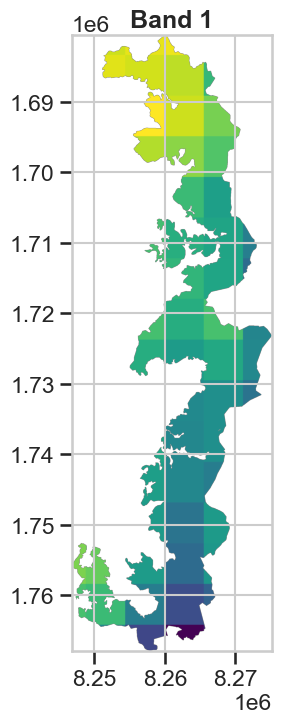

Error analyzing trend layer: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).


<Figure size 640x480 with 0 Axes>

In [20]:
# CELL 5: Trend Layers Analysis

try:
    # Try to load the trend layer TIF file
    trend_file = "inputResampled.tif" 
    trend_path = os.path.join(data_dir, trend_file)
    
    if os.path.exists(trend_path):
        # Open the raster file
        with rasterio.open(trend_path) as src:
            # Print metadata
            print(f"Trend layer loaded successfully.")
            print(f"Driver: {src.driver}")
            print(f"Width: {src.width}, Height: {src.height}")
            print(f"Bounds: {src.bounds}")
            print(f"CRS: {src.crs}")
            print(f"Number of bands: {src.count}")
            print(f"Data types: {src.dtypes}")
            
            # Read and analyze the first band
            band_to_show = 1  # Start with the first band
            band_data = src.read(band_to_show)
            
            # Get statistics for the band
            band_min = band_data.min()
            band_max = band_data.max()
            band_mean = band_data.mean()
            band_std = band_data.std()
            
            print(f"\nBand {band_to_show} statistics:")
            print(f"Min: {band_min}, Max: {band_max}, Mean: {band_mean:.2f}, Std: {band_std:.2f}")
            
            # Plot the band
            plt.figure(figsize=(10, 8))
            show(band_data, transform=src.transform, cmap='viridis', title=f"Band {band_to_show}")
            plt.colorbar(label=f"Band {band_to_show} Value")
            plt.savefig(f'img/trend_layer_band_{band_to_show}.png')
            print(f"Saved plot: trend_layer_band_{band_to_show}.png")
            
            # If there are multiple bands, show a few more
            if src.count > 1:
                for band_idx in range(2, min(4, src.count + 1)):
                    band = src.read(band_idx)
                    plt.figure(figsize=(10, 8))
                    show(band, transform=src.transform, cmap='viridis', title=f"Band {band_idx}")
                    plt.colorbar(label=f"Band {band_idx} Value")
                    plt.savefig(f'img/trend_layer_band_{band_idx}.png')
                    print(f"Saved plot: trend_layer_band_{band_idx}.png")
    else:
        print(f"The trend layer file '{trend_file}' was not found.")
        print("According to the README, it can be downloaded from:")
        print("https://www.dropbox.com/scl/fi/ena1qfeqv5ppshluop8kt/inputResampled.tif?rlkey=arefwl3my7nx3z5qpknu88lsx&st=vj8cn3bd&dl=0")
except Exception as e:
    print(f"Error analyzing trend layer: {e}")

In [21]:
# CELL 6: Model Training and Testing Dataset Evaluation

try:
    if 'fire_all' in locals() and len(fire_all) > 0:
        # Count total events
        total_events = len(fire_all)
        print(f"\nModel Training and Testing Dataset Evaluation:")
        print(f"Total fire events: {total_events}")
        
        # Define training period (e.g., 2013-2020) and testing period (e.g., 2021-2023)
        if 'year' in fire_all.columns:
            train_years = range(2013, 2021)  # Adjust as needed
            test_years = range(2021, 2024)   # Adjust as needed
            
            train_events = fire_all[fire_all['year'].isin(train_years)]
            test_events = fire_all[fire_all['year'].isin(test_years)]
            
            print(f"Training events (2013-2020): {len(train_events)}")
            print(f"Testing events (2021-2023): {len(test_events)}")
            
            # Check if we have enough events for both periods
            train_sufficient = len(train_events) >= 100  # Arbitrary threshold
            test_sufficient = len(test_events) >= 30     # Arbitrary threshold
            
            print(f"\nTraining data sufficient: {'Yes' if train_sufficient else 'No'}")
            print(f"Testing data sufficient: {'Yes' if test_sufficient else 'No'}")
            
            # Check for temporal gaps
            year_counts = fire_all.groupby('year').size()
            all_years = set(range(min(fire_all['year']), max(fire_all['year']) + 1))
            missing_years = all_years - set(year_counts.index)
            
            if missing_years:
                print(f"\nWarning: Missing data for years: {missing_years}")
            else:
                print("\nNo temporal gaps in the data.")
        else:
            print("Year information not available to assess temporal distribution.")
    else:
        print("Fire event data not available for model evaluation.")
except Exception as e:
    print(f"Error evaluating model data requirements: {e}")


Model Training and Testing Dataset Evaluation:
Total fire events: 267
Training events (2013-2020): 206
Testing events (2021-2023): 61

Training data sufficient: Yes
Testing data sufficient: Yes

No temporal gaps in the data.


In [10]:
# CELL 7: Summary of Findings and Recommendations

print("\n" + "="*50)
print("SUMMARY OF FINDINGS AND RECOMMENDATIONS")
print("="*50)

findings = []
recommendations = []

# Check if we have the key datasets
if 'fire_all' in locals() and len(fire_all) > 0:
    findings.append(f"- Found {len(fire_all)} fire events.")
    if 'year' in fire_all.columns:
        years = sorted(fire_all['year'].unique())
        findings.append(f"- Fire events cover {len(years)} years from {min(years)} to {max(years)}.")
else:
    findings.append("- Fire event data is missing or could not be loaded.")
    recommendations.append("- Acquire or fix the fire event datasets (fire13_19.shp and fire20_23.shp).")

if 'boundary' in locals():
    findings.append("- Study area boundary data is available.")
else:
    findings.append("- Study area boundary data is missing or could not be loaded.")
    recommendations.append("- Ensure the pa_boundary.shp file is available and properly formatted.")

# Check for the trend layer file
if os.path.exists(os.path.join(data_dir, "inputResampled.tif")):
    findings.append("- The trend layer file (inputResampled.tif) is available locally.")
else:
    findings.append("- The trend layer file (inputResampled.tif) is not available locally.")
    recommendations.append("- Download the trend layer file from the Dropbox link provided in the README.")

# Check for the road data
if os.path.exists(os.path.join(data_dir, "road.tif")):
    findings.append("- The road layer file (road.tif) is available.")
else:
    findings.append("- The road layer file (road.tif) is not available or could not be loaded.")
    recommendations.append("- Ensure the road.tif file is available for fire vulnerability mapping.")

# Model training/testing dataset assessment
if 'train_sufficient' in locals() and 'test_sufficient' in locals():
    if train_sufficient and test_sufficient:
        findings.append("- The dataset appears to have sufficient fire events for both training and testing.")
    else:
        if not train_sufficient:
            findings.append("- The training dataset may not have enough fire events.")
            recommendations.append("- Consider acquiring more historical fire data for training.")
        if not test_sufficient:
            findings.append("- The testing dataset may not have enough fire events.")
            recommendations.append("- Consider using cross-validation techniques to maximize use of available data.")

# Display findings and recommendations
print("\nFINDINGS:")
for finding in findings:
    print(finding)

print("\nRECOMMENDATIONS:")
if recommendations:
    for recommendation in recommendations:
        print(recommendation)
else:
    print("- All necessary data appears to be available and sufficient for the analysis.")

print("\nNext Steps:")
print("1. Ensure all required datasets are downloaded and properly formatted")
print("2. Prepare training and testing datasets based on appropriate temporal splits")
print("3. Apply the methodology described in the README for fire vulnerability mapping")
print("4. Evaluate model performance using metrics like precision, recall, and F1-score")
print("5. Generate predictions for future fire-prone areas")

print("\nThis script generated several visualization files. Check your directory for the PNG files.")



SUMMARY OF FINDINGS AND RECOMMENDATIONS

FINDINGS:
- Found 267 fire events.
- Fire events cover 11 years from 2013 to 2023.
- Study area boundary data is available.
- The trend layer file (inputResampled.tif) is available locally.
- The road layer file (road.tif) is available.
- The dataset appears to have sufficient fire events for both training and testing.

RECOMMENDATIONS:
- All necessary data appears to be available and sufficient for the analysis.

Next Steps:
1. Ensure all required datasets are downloaded and properly formatted
2. Prepare training and testing datasets based on appropriate temporal splits
3. Apply the methodology described in the README for fire vulnerability mapping
4. Evaluate model performance using metrics like precision, recall, and F1-score
5. Generate predictions for future fire-prone areas

This script generated several visualization files. Check your directory for the PNG files.
